# Interactive Bayesian updating: coin flipping example

## <a name="Python">Python/Jupyter set up</a>

In [1]:
%matplotlib notebook

In [2]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox, Button
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

from IPython.display import display

import seaborn as sns
sns.set()
sns.set_context("talk")


## <a name="Updating">Bayesian updating examples</a>

$  \newcommand{\thetavec}{\boldsymbol{\theta}} \newcommand{\pr}{\textrm{p}}$
Recall Bayes' theorem with $\thetavec$ the vector of parameters we seek and information $I$ is kept implicit.

$$
  \overbrace{\pr(\thetavec \mid \textrm{data},I)}^{\textrm{posterior}} =
  \frac{\color{red}{\overbrace{\pr(\textrm{data} \mid \thetavec,I)}^{\textrm{likelihood}}} \times
   \color{blue}{\overbrace{\pr(\thetavec \mid I)}^{\textrm{prior}}}}
   {\color{darkgreen}{\underbrace{\pr(\textrm{data} \mid I)}_{\textrm{evidence}}}}
$$

If we view the prior as the initial information we have about $\thetavec$, summarized as a probability density function, then Bayes' theorem tells us how to <em>update</em> that information after observing some data: this is the posterior pdf.  Here we will give some examples of how this plays out when tossing coins.


### Determining the bias of a coin

The idea here is that we are observing successive flips of a coin, which is a proxy for any process that has a binary outcome.  There is a definite true probability for getting heads, which we'll label $p_h$, but we don't know what it is.  We start with a preconceived notion of the probability expressed in terms of a prior pdf for $p_h$, i.e., $\pr(p_h)$.  With each flip of the coin, we have more information, so our goal is to <em>update</em> our expectation of $p_h$, meaning we want the posterior $\pr(p_h \mid \mbox{# tosses, # heads})$. 

#### Main code for coin-flipping UI

<IPython.core.display.Javascript object>


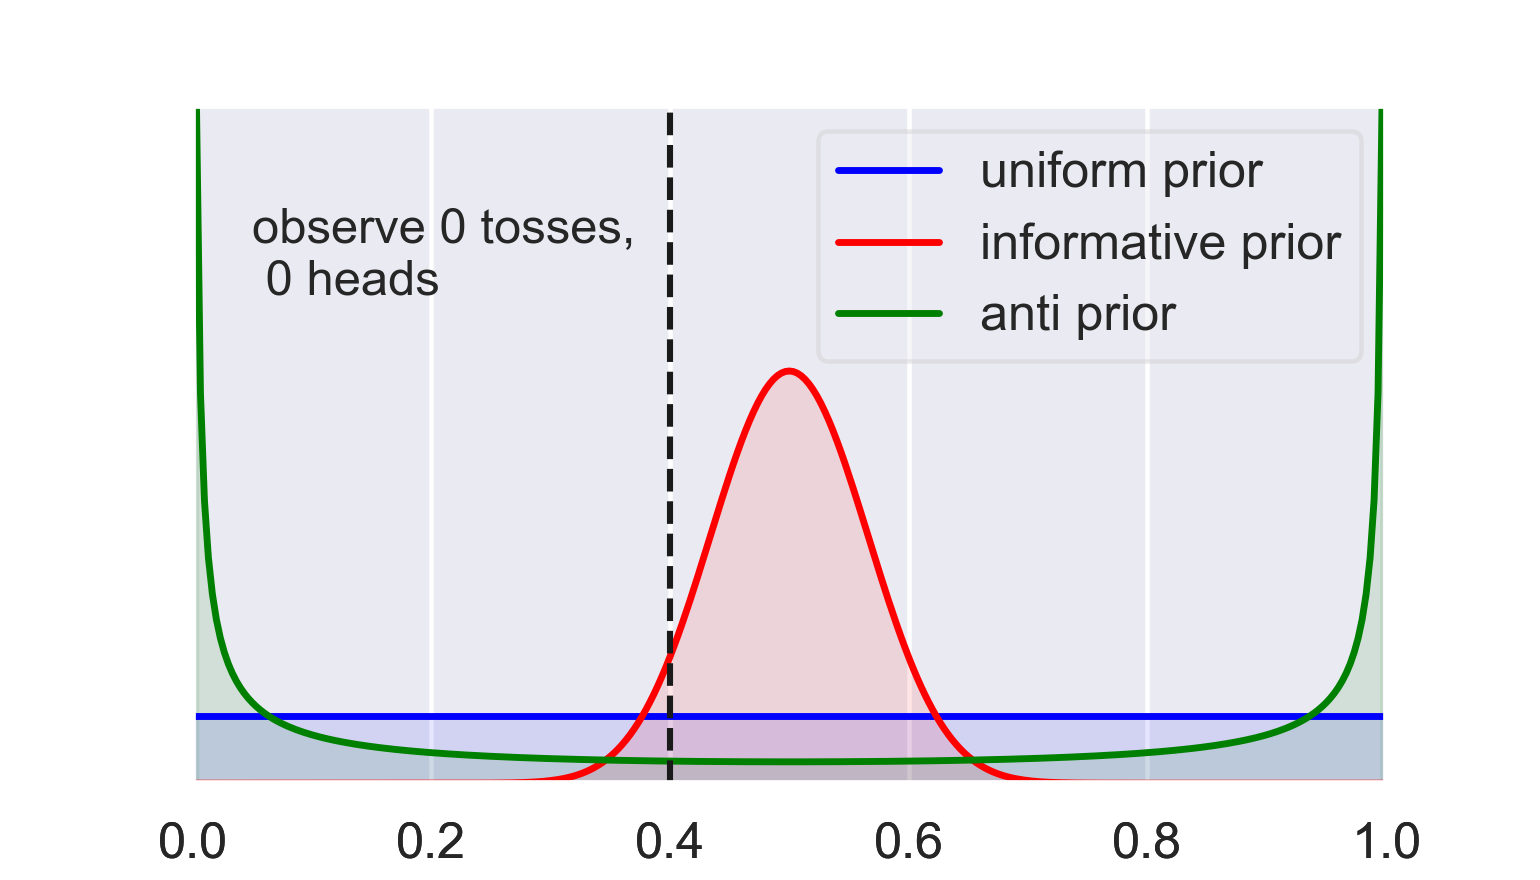

In [3]:
# Initial values (can be changed by widgets)
n_trials_max = 5000          # maximum number of coin tosses
prob_heads = 0.4             # p_h, the true probability of a heads
x = np.linspace(0, 1, 301)   # mesh for posterior plots (enough so smooth)

class Data():
    """Class to hold the array of heads and tails (1s and 0s) outcomes."""
    def __init__(self, prob_heads=0.5, n_trials_max=5000):
        self._data = self.generate_data(prob_heads, n_trials_max)
        
    def generate_data(self, prob_heads, n_trials_max):
        """Generate an array of heads or tails, 1 or 0, for n_trials_max
           independent tosses according to the Bernoulli distribution."""
        self._data = stats.bernoulli.rvs(prob_heads, size=n_trials_max)
    
    def heads_in_data_to_N(self, N):
        """Count how many heads in the first N elements of the data."""
        return self._data[:N].sum()

coin_data = Data(prob_heads, n_trials_max)    
    

fig = plt.figure(figsize=(7,4))
    
def update_plot(N=0, jump=1, recalculate_data=True, 
                prob_heads=0.5, n_trials_max=5000,
                alpha_1=1., beta_1=1.,
                alpha_2=30., beta_2=30.,
                alpha_3=0.2, beta_3=0.3
               ):
    """
    Make a new plot based on the current widget settings for the input
    parameters.
    """  
    
    font_size = 16
    plt.rcParams.update({'font.size': font_size})
        
    if recalculate_data:
        coin_data.generate_data(prob_heads, n_trials_max)
        recalculate_data_w.value = False

    heads = coin_data.heads_in_data_to_N(N)   # add up the 1s (= # of heads)
    # update using the conjugate prior, which is a beta pdf
    y_1 = stats.beta.pdf(x, alpha_1 + heads, beta_1 + N - heads)    
    y_2 = stats.beta.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
    y_3 = stats.beta.pdf(x, alpha_3 + heads, beta_3 + N - heads)   

    # default y_3 distribution has two high max at endpoints for plot
    y_max = np.max([y_1.max(), y_2.max()])  
    
    ax = fig.add_subplot(1, 1, 1)

    line1, = ax.plot(x, y_1, label="uniform prior", color="blue")
    ax.fill_between(x, 0, y_1, color="blue", alpha=0.1)
    line2, = ax.plot(x, y_2, label="informative prior", color="red")
    ax.fill_between(x, 0, y_2, color="red", alpha=0.1)
    line3, = ax.plot(x, y_3, label="anti prior", color="green")
    ax.fill_between(x, 0, y_3, color="green", alpha=0.1)
     
    ax.set_xlabel("$p_h$, probability of heads") 
    ax.set_yticks([])  # turn off the plotting of ticks on the y-axis
    ax.axvline(prob_heads, 0, 1.1*y_max, color="k", linestyle="--", lw=2)
    ax.annotate(f'observe {N:d} tosses,\n {heads:d} heads', 
                xy=(0.05,0.85), xycoords='axes fraction', 
                horizontalalignment='left',verticalalignment='top')
    leg = ax.legend(loc='upper right')
    leg.get_frame().set_alpha(0.4)
    ax.autoscale(tight=True)
    
    
################### begin: text for help tabs ##################
# In HTML (could move this to an external file!)
overview_text = \
   r"""<p>Here we explore Bayesian updating for a coin flip. There is help 
          available under the other tabs.</p>  
          <ul>
            <li>Bayes theorem tab: find out about Bayesian updating.
            <li>Toss coin tab: find out what the controls do.
            <li>Priors tab: change the three initial priors.
            <li>Setup tab: change how the plots are made.
          </ul>      
    """ 
Bayes_text = \
    r"""
    <p>Recall Bayes' theorem with $\thetavec$ the vector of parameters 
    we seek and information $I$ is kept implicit.</p>

    $$
     \newcommand{\thetavec}{\boldsymbol{\theta}}
     \overbrace{p(\thetavec \mid \textrm{data},I)}^{\textrm{posterior}} =
     \frac{\color{red}{\overbrace{p(\textrm{data} 
     \mid \thetavec,I)}^{\textrm{likelihood}}} \times
      \color{blue}{\overbrace{p(\thetavec \mid I)}^{\textrm{prior}}}}
      {\color{darkgreen}{\underbrace{p(\textrm{data} 
         \mid I)}_{\textrm{evidence}}}}
   $$

    <p>If we view the prior as the initial information we have about 
     $\thetavec$, summarized as a probability density function, 
     then Bayes' theorem tells us how to <em>update</em> that 
     information after observing some data: this is the posterior pdf.  
     Here we will look at an example of how this plays out in practice:
     flipping a (biased) coin.</p>     

    <br>

    <p>The idea here is that we are observing successive flips of a coin, 
    which is a proxy for any process that has a binary outcome.  
    There is a definite true probability for getting heads, 
    which we'll label $p_h$, but we don't know what it is.  
    We start with a preconceived notion of the probability expressed 
    in terms of a prior pdf for $p_h$, i.e., $p(p_h)$.  
    With each flip of the coin, we have more information, so our goal is 
    to <em>update</em> our expectation of $p_h$, meaning we want the 
    posterior $p(p_h\mid \mbox{# tosses, # heads})$.</p> 

   """

toss_coin_text = \
    r"""
    The graph shows three posteriors that result from three choices for
    the prior (see the "Priors" tab for details) for the number of coin
    tosses and observed heads shown at the upper left. The true probability
    of a heads, $p_h$, is indicated by a dashed vertical line.
    <ul>
      <li>The "Next" button advances the number of coin tosses by the
        amount shown after "Jump".
      <li>The "Jump" pulldown is used to set how many observations are
       made with each press of the "Next" button.
      <li>The "Reset" button sets the number of observations back to zero.
      <li>The probability of heads $p_h$ can be adjusted between 0 and
      1 using the slider.
    </ul>
    """

setup_text = \
    r"""
    Select the maximum number of trials possible.  The calculations will
    simply stop if you try to go higher.
    """

initial_text = \
    r"""
    The graph shows three posteriors that result from three choices for
    the prior (set under the "Priors" tab) for the number of coin
    tosses and observed heads shown at the upper left. The true probability
    of a heads, $p_h$, is indicated by a dashed vertical line.
    Press "Next" to make observations, "Reset" to go back to zero.
    """
initial_text_w = HTMLMath(value=initial_text)

priors_text = \
    r"""
    Hyperparameters for several different priors (all beta distributions).
    Default prior 1 ($\alpha_1 = 1$, $\beta_1 = 1$) is uniform in [0,1].
    Default prior 2 ($\alpha_2 = 30$, $\beta_2 = 30$) is concentrated 
    near 0.5 with very small tails.
    Defalt prior 3 ($\alpha_3 = .2$, $\beta_3 = .2$) is peaked at the ends, 
    but allows for probability everywhere.
    """
priors_text_w = HTMLMath(value=priors_text)
################### end: text for help tabs ##################
    
    
    
    
################### begin: definitions of widgets ##################
recalculate_data_w = Checkbox(value=True)    
prob_heads_w = FloatSlider(value=prob_heads, min=0., max=1., step=0.05,
                           description=r'true $p_h$:',
                           continuous_update=False)
n_trials_max_w = IntSlider(value=n_trials_max, min=100, max=10000, step=100,
                           description='max # trials:',
                           continuous_update=False)
 
N_w = IntSlider(value=0, min=0, max=n_trials_max, step=1,
                continuous_update=False)
next_button_w = Button(description='Next', disabled=False,
                       layout=Layout(width='80px'), button_style='', 
                       tooltip='Increment number of trials by jump')
reset_button_w = Button(description='Reset', disabled=False,
                        layout=Layout(width='80px'), button_style='', 
                        tooltip='Reset number of trials to zero')
new_data_button_w = Button(description='New data', disabled=False,
                           layout=Layout(width='80px'), button_style='', 
                           tooltip='Generate new data with a different seed')

jump_w = Dropdown(description='Jump:',
                  layout=Layout(width='150px'),
                  options=['1', '10', '100', '1000'],
                  value='1',
                  continuous_update=False,
                  disabled=False,)

alpha_1_w = FloatSlider(value=1., min=0., max=2., step=0.1,
                           description=r'$\alpha_1$:',
                           continuous_update=False)
alpha_1_w.style.handle_color = 'blue'

alpha_2_w = FloatSlider(value=30., min=5., max=200., step=5.,
                           description=r'$\alpha_2$:',
                           continuous_update=False)
alpha_2_w.style.handle_color = 'red'
alpha_3_w = FloatSlider(value=0.2, min=0., max=1., step=0.1,
                           description=r'$\alpha_3$:',
                           continuous_update=False)
alpha_3_w.style.handle_color = 'green'
beta_1_w = FloatSlider(value=1., min=0.1, max=2., step=0.1,
                           description=r'$\beta_1$:',
                           continuous_update=False)
beta_1_w.style.handle_color = 'blue'
beta_2_w = FloatSlider(value=30., min=5., max=200., step=5.,
                           description=r'$\beta_2$:',
                           continuous_update=False)
beta_2_w.style.handle_color = 'red'
beta_3_w = FloatSlider(value=0.2, min=0., max=1., step=0.1,
                           description=r'$\beta_3$:',
                           continuous_update=False)
beta_3_w.style.handle_color = 'green'

# Widgets for the help section, which are HTMLMath boxes in a Tab widget
help_overview_w = HTMLMath(value=overview_text)
help_Bayes_w = HTMLMath(value=Bayes_text)
help_toss_coin_w = HTMLMath(value=toss_coin_text)
help_priors_w = HTMLMath(value=priors_text)
help_setup_w = HTMLMath(value=setup_text)

################### end: definitions of widgets ##################

################### begin: explicit widget callbacks ##################
def update_N(b):
    """Increment the number of trials N by the Jump value"""
    N_w.value += int(jump_w.value)
    
def reset_N(b):
    """Reset the number of trials N to zero"""
    N_w.value = 0
    
def regenerate_data(b):
    """Generate the data again with a different random see."""
    recalculate_data_w.value = True
    
def update_prob_heads(b):
    """Change the value of prob_heads and regenerate data."""
    recalculate_data_w.value = True
    N_w.max = n_trials_max_w.value

next_button_w.on_click(update_N)
new_data_button_w.on_click(regenerate_data)
reset_button_w.on_click(reset_N)
 
prob_heads_w.observe(update_prob_heads, 'value')    
n_trials_max_w.observe(update_prob_heads, 'value')    

################### end: explicit widget callbacks ##################


# Organize the help as Tabs (which will be itself under the Help Tab)
help_max_height = '500px'
help_tab = Tab(children=[help_overview_w, help_Bayes_w, help_toss_coin_w, 
                         help_priors_w, help_setup_w], 
               layout=Layout(width='95%', max_height=help_max_height))
help_tab.set_title(0, 'Overview')
help_tab.set_title(1, 'Bayes Theorem')
help_tab.set_title(2, 'Toss Coin')
help_tab.set_title(3, 'Priors')
help_tab.set_title(4, 'Set-up')
    
# Boxes of widgets that will go into the top-level tabs
textbox0 = HBox([initial_text_w])
hbox0 = HBox([next_button_w, jump_w, reset_button_w, new_data_button_w,
              prob_heads_w])
textbox1 = HBox([priors_text_w])
hbox1a = HBox([alpha_1_w, alpha_2_w, alpha_3_w])
hbox1b = HBox([beta_1_w, beta_2_w, beta_3_w])
hbox2 = HBox([n_trials_max_w])
hbox3 = HBox([help_tab])

# We'll set up Tabs to organize the controls.  The Tab contents are declared
#  as tab0, tab1, ... (probably should make this a list) and the overall Tab
#  is called tab (so its children are tab0, tab1, ...).
tab_height = '70px'  # Fixed minimum height for all tabs. Specify another way?
tab0 = VBox([textbox0, hbox0], layout=Layout(min_height=tab_height))
tab1 = VBox([textbox1, hbox1a, hbox1b], layout=Layout(min_height=tab_height))
tab2 = VBox([hbox2], layout=Layout(min_height=tab_height))
tab3 = VBox([hbox3], layout=Layout(min_height=tab_height))

tab = Tab(children=[tab0, tab1, tab2, tab3])
tab.set_title(0, 'Toss Coin')
tab.set_title(1, 'Priors')
tab.set_title(2, 'Set-up')
tab.set_title(3, 'Help')

plot_out = widgets.interactive_output(update_plot,
                                      dict(
                                           N=N_w,
                                           jump=jump_w,
                                           recalculate_data=recalculate_data_w,
                                           prob_heads=prob_heads_w,
                                           n_trials_max=n_trials_max_w,
                                           alpha_1=alpha_1_w, beta_1=beta_1_w,
                                           alpha_2=alpha_2_w, beta_2=beta_2_w,
                                           alpha_3=alpha_3_w, beta_3=beta_3_w,
                                      )
                                     )

UI_box = VBox([tab, plot_out])
display(UI_box)

#### User-interface for coin-flipping 

Take a look at the information under the `Help` tab to find out about what the controls do, what the priors are, etc. 

Questions and tasks relating to priors and dealing with uncertainty: 
* *What prior would you choose? How does this affect how long it takes you to arrive at the correct conclusion?* Note that the answer to this question may be $p_H$ dependent.
* *What would your standard be for deciding the coin was so unfair that you would walk away? That you'd call the police? That you'd try and publish the fact that you found an unfair coin in a scientific journal?* Hint: for the last one try thinking in terms of a "p value". If you don't know what that mean google "hypothesis testing".
* *What if you were **sure** the coin was unfair before you started? (E.g. you saw the person doctoring it.) What prior would you choose then? What happens to the posterior in this case?*  This one may be best answered without any hitting of shift-return.....


## Degree of belief intervals

Now we are going to compute some Bayesian confidence intervals, aka DoB intervals, aka credibility intervals....
You should go through this section once using the numbers provided, and then come back and run it again (or copy-paste the relevant lines) for other results from the widget. You can also employ priors other than those provided if you wish, but that takes a bit more work.

First we paste code from the "Playing with pdfs" notebook:

In [4]:
def dist_stuff(dist):
    """
    Finds the median, mean, and 68%/95% credible intervals for the given 
    1-d distribution (which is an object from scipy.stats).  
    """
    # For x = median, mean: return x and the value of the pdf at x as a list
    median = [dist.median(), dist.pdf(dist.median())]  
    mean = [dist.mean(), dist.pdf(dist.mean())]
    # The left and right limits of the credibility interval are returned
    cred68 = dist.interval(0.68)
    cred95 = dist.interval(0.95)
    return median, mean, cred68, cred95

In [5]:
def dist_mode(dist, x):
    """
    Return the mode (maximum) of the 1-d distribution for array x.
    """
    x_max_index = dist.pdf(x).argmax()
    # Return x of the maximum and the value of the pdf at that x 
    mode = [x[x_max_index], dist.pdf(x[x_max_index])]
    return mode

Then we use this to write a function that will give us back the mean, 68%, and 95% intervals for a uniform prior. 

In [6]:
def print_uniform_prior_measures(N,heads):
    """
    Prints out the mean, and 68 and 95 CIs for a uniform prior. 
     Note that this means alpha=beta=1.
    """
    median, mean, cred68, cred95 = dist_stuff(stats.beta(1+heads,1+N-heads))
    mode = dist_mode(stats.beta(1+heads,1+N-heads),x)
    print('For a uniform prior, and', heads, 'heads out of', N, 'tosses:')
    print (f'Mean = {mean[0]:.3f}; Mode = {mode[0]:.3f}')
    print (f'68% DoB interval = ({cred68[0]:.3f}, {cred68[1]:.3f})')
    print (f'95% DoB interval = ({cred95[0]:.3f}, {cred95[1]:.3f})')
    return                              

Now we fill in the values for N and heads from running the widget. Suppose it gave 3 heads out of 14 tosses. 

In [7]:
print_uniform_prior_measures(14, 3)

For a uniform prior, and 3 heads out of 14 tosses:
Mean = 0.250; Mode = 0.213
68% DoB interval = (0.144, 0.356)
95% DoB interval = (0.078, 0.481)


In [8]:
print(f'The actual value of p_H is', prob_heads)

The actual value of p_H is 0.4


So, at least for the data this time, the 68% DoB for a uniform prior does _not_ contain the true value, but the 95% one does. *Are you surprised by that? Should you be?*

In [9]:
def print_frequentist_estimators(N, heads):
    """
    Finds the mean, and 68 and 95 CIs for a uniform prior. 
     Note that this means alpha_1=beta_1=1.
    """
    mean = heads / N
    sigma = np.sqrt(mean * (1 - mean) /N)
    print(f'For {heads} heads out of {N} tosses,',
          f'the frequentist 1-sigma interval =',
          f'({mean-sigma:.3f} , {mean+sigma:.3f})')
    return

In [10]:
print_frequentist_estimators(14, 3)

For 3 heads out of 14 tosses, the frequentist 1-sigma interval = (0.105 , 0.324)


*Which Bayesian estimator is the frequentist mean closest to?*

*Is the frequentist 1$\sigma$ interval the same as the Bayesian 68% DoB interval? If so, should they be? If not, why are they different?*

Now we will also generate the summary statistics for the other priors. (What is coded is for the default values. After running through the exercise you can come back and try and change it; indeed, you should do that if you comparing to results where you altered the prior above.)

In [11]:
def print_likely_fair_prior_measures(N,heads):
    """
    Prints out the mean, and 68 and 95 CIs for the "coin is likely fair" 
     prior. This means alpha = beta = 30.
    """
    median, mean, cred68, cred95 = dist_stuff(stats.beta(30+heads,30+N-heads))
    mode=dist_mode(stats.beta(1+heads,1+N-heads),x)
    print(f'For the trusting-person\'s prior and {heads} heads',
          f'out of {N} tosses:')
    print (f'Mean = {mean[0]:.3f}; Mode = {mode[0]:.3f}')
    print (f'68% DoB interval = ({cred68[0]:.3f}, {cred68[1]:.3f})')
    print (f'95% DoB interval = ({cred95[0]:.3f}, {cred95[1]:.3f})')
    return              

In [12]:
print_likely_fair_prior_measures(14, 3)

For the trusting-person's prior and 3 heads out of 14 tosses:
Mean = 0.446; Mode = 0.213
68% DoB interval = (0.388, 0.503)
95% DoB interval = (0.335, 0.559)


In [13]:
def print_likely_unfair_prior_measures(N,heads):
    """
    Prints out the mean, and 68 and 95 CIs for the "coin is likely unfair" prior. This means alpha=beta=0.2.
    """
    median, mean, cred68, cred95 = dist_stuff(stats.beta(0.2+heads,0.2+N-heads))
    mode=dist_mode(stats.beta(1+heads,1+N-heads),x)
    print(f'For the nasty-suspicious-mind prior and {heads} heads '
          f'out of {N} tosses:')
    print (f'Mean = {mean[0]:.3f}; Mode = {mode[0]:.3f}')
    print (f'68% DoB interval = ({cred68[0]:.3f}, {cred68[1]:.3f})')
    print (f'95% DoB interval = ({cred95[0]:.3f}, {cred95[1]:.3f})')
    return              

In [14]:
print_likely_unfair_prior_measures(14, 3)

For the nasty-suspicious-mind prior and 3 heads out of 14 tosses:
Mean = 0.222; Mode = 0.213
68% DoB interval = (0.116, 0.329)
95% DoB interval = (0.056, 0.461)


*So what is the best approach in this case? Objectivity? Trust? Suspicion?*

*Now having printed out the results for my particular coin-tossing experiment you should play with things and see what the different summary statistics give for other "experimental runs".*